In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba as nb
import charges as charges
import plotting as plotting
from itertools import combinations

In [2]:
def euclidean_vec(combs):
    """ Compute the euclidean distance between two points
    """

    return np.sqrt((combs[:,0]- combs[:,2])**2 + (combs[:,1]- combs[:,3])**2)
    # return np.linalg.norm(p2 - p1)

def evaluate_configuration_fast(particles):
    """No idea if this is acc faster."""

    # generate combinations
    m, n = particles.shape
    comb = np.zeros((m, m, n + n), dtype=float)
    comb[:, :, :n] = particles[:, None, :]
    comb[:, :, n:] = particles
    comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
    # now we also get p1 -p1 combinations, but
    # their inter-particle distance is 0, so we can ignore that fact
    d = euclidean_vec(comb)
    return 1/np.sum(d[d != 0])

def euclidean(p1, p2):
    """ Compute the euclidean distance between two points
    """
    return np.linalg.norm(p2 - p1)

def evaluate_configuration(particles):
    """ Calculate the total energy of the current configuration
    """
    total = 0
    for i, j in list(combinations(range(len(particles)), 2)):
        p1, p2 = particles[i], particles[j]
        total += 1 / euclidean(p1, p2)

    return total

---------------


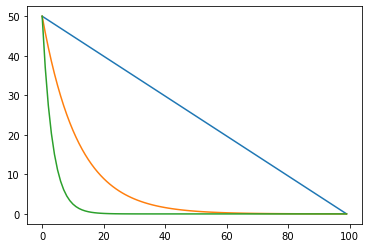

In [3]:
high_temp = 50;
low_temp = 0.01;
n_temps = 100
exponential_even = np.geomspace(high_temp, low_temp, n_temps)
exponential_0003 = np.exp(-np.arange(0, n_temps) * 30 / n_temps) * high_temp
linear = np.linspace(high_temp, low_temp, n_temps)
plt.plot(linear)
plt.plot(exponential_even)
plt.plot(exponential_0003)
#
# tst_n = [high_temp * math.exp(-0.001*x) for x in range(n_temps)]

In [4]:
import matplotlib.cm as cm

def plot_ez(init_points, res):
    points = res

    theta = np.linspace(0, 2 * np.pi, 150)
    a = 1 * np.cos(theta)
    b = 1 * np.sin(theta)

    fig, ax = plt.subplots(1, figsize = (8,8))
    ax.plot(a, b, color='black')
    # plotpoints = []
    # for p in points:
    colors = list(cm.rainbow(np.linspace(0, 1, len(points))))
    for i in range(len(points)):
        ax.scatter(init_points[i,0], init_points[i,1],color=colors[i])
        ax.scatter(points[i,0], points[i,1],s=100,marker='X',color=colors[i])
    # scatter = ax.scatter(init_points[:,0], init_points[:,1], color='black',label='before')
    # scatter = ax.scatter(points[:,0], points[:,1], color='red',s=100,marker='x', label = 'black')
    plt.title("%d" % len(res))
    ax.set_aspect(1)
    # plt.legend()

In [ ]:


my_charge = charges.Charges(12,1,step_size=0.001)
init_points = my_charge.particles
# print(init_points)
# my_charge.evaluate_configuration()
# my_charge.evaluate_configuration_fast() # does not work, div by 0
colors = cm.rainbow(np.linspace(0, 1, len(init_points)))
res = my_charge.iterate_SA_optimize(0.1,50,500_000,'test', True)

# evaluate_configuration_fast(res)

# m, n = res.shape
# comb = np.zeros((m, m, n + n), dtype=float)
# comb[:, :, :n] = res[:, None, :]
# comb[:, :, n:] = res
# comb.shape = (m * m, -1) # shape is 4 columns w len(particles) rows
# print(comb)
# # now we also get p1 -p1 combinations, but
# # their inter-particle distance is 0, so we can ignore that fact
#
# 1/np.sum(euclidean_vec(comb))



In [ ]:
plot_ez(res,res)

In [ ]:
print(evaluate_configuration_fast(init_points))
print(evaluate_configuration_fast(res))

In [ ]:
my_data = np.loadtxt('logged_data/20_exponential_0.003_200000.csv', delimiter=',',skiprows=1)

In [ ]:
my_data

In [ ]:
plt.plot(my_data)